In [7]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=50)

# 深度学习的三个步骤

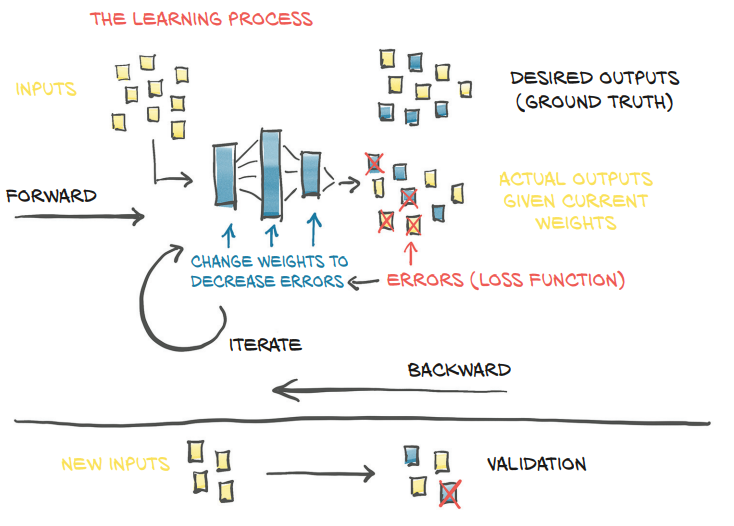

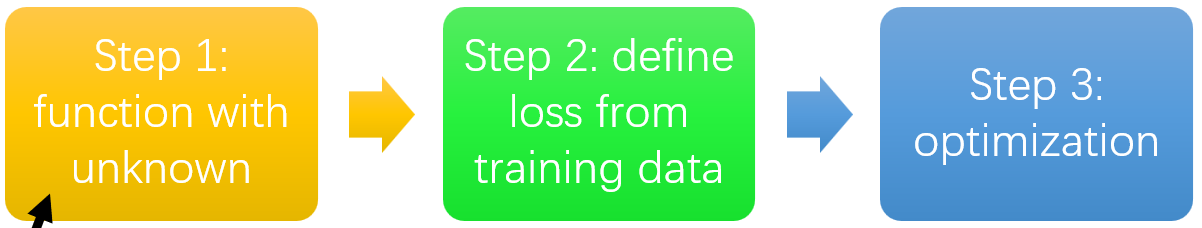


In [8]:
# t_c 摄氏度 t_u华氏温度

t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)


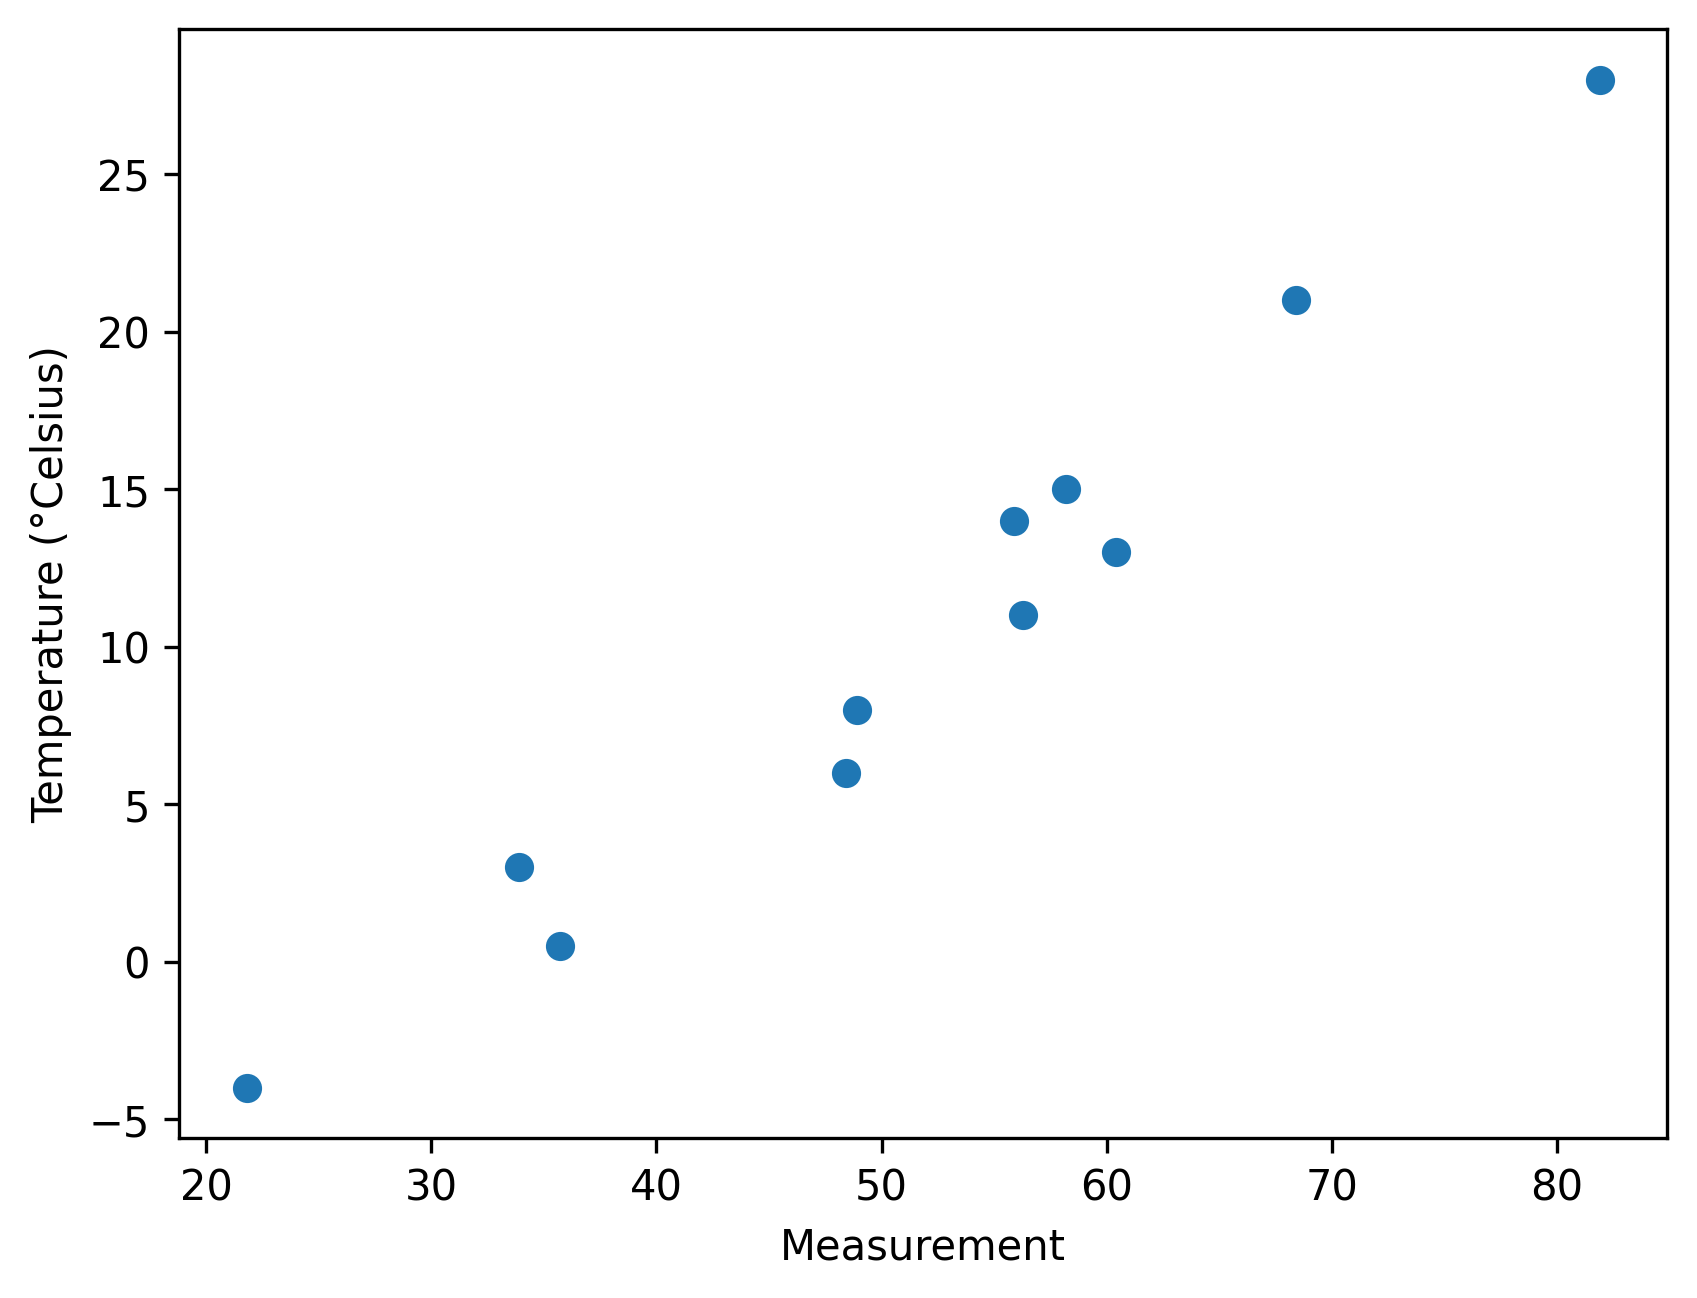

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=300)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")

# 1  Choosing a linear model as a first try （选择模型）

In [10]:
## 定义模型，根据先验经验是线性关系
def model(t_u, w, b):
    return w * t_u + b

# 2   Less loss is what we want （定义损失）

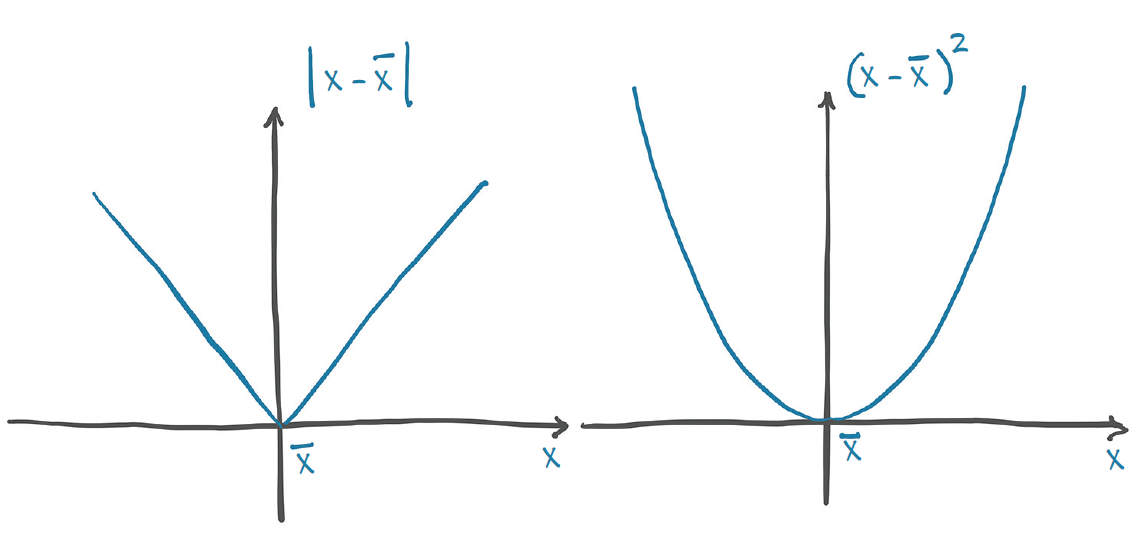


In [11]:
## 定义模型，根据先验经验是线性关系
def loss_fn(t_p, t_c):
    squared_diffs = 0.5*(t_p - t_c)**2
    return squared_diffs.mean()

In [12]:
##  初始化参数，预测结果t_p
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000,
        56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [13]:
loss = loss_fn(t_p, t_c)
loss

tensor(881.9424)

# 3   Down along the gradient（梯度下降） （optimization）

In [16]:
### 计算梯度，自己定义计算梯度

delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

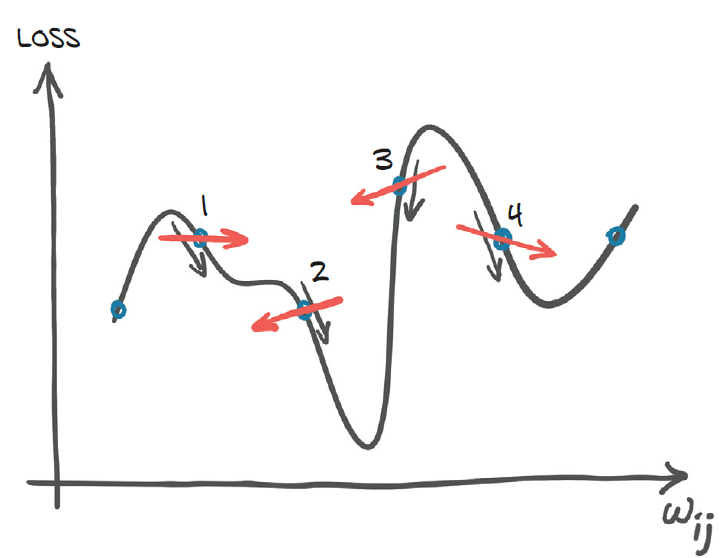

In [17]:
### 定义学习率，迭代梯度算法

learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [18]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

###  计算损失函数的微分

In [17]:
def dloss_fn(t_p, t_c):
    dsq_diffs =  (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

# d x^2/dx=2x

### 将倒数应用到模型中
回想我们的线性模型 tp=t_u*w+b

In [18]:
def dmodel_dw(t_u, w, b):
    return t_u

In [19]:
def dmodel_db(t_u, w, b):
    return 1.0

### 定义梯度函数 

In [20]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)   # 定义损失函数
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b) # 关于权重w的梯度
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b) # 关于偏置b的梯度
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1>

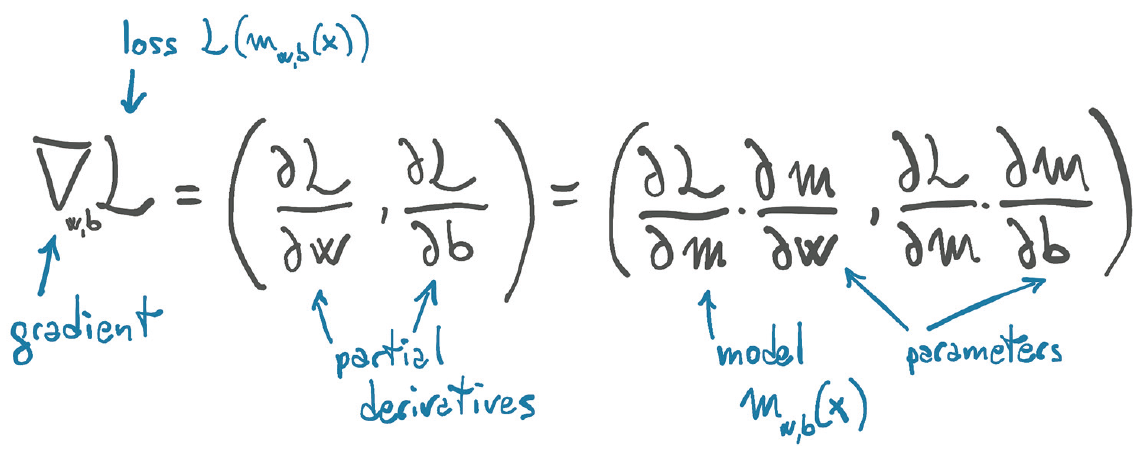

#  3 优化-迭代以适应模型

### 定义循环训练函数 

In [21]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

### 循环训练

In [22]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [23]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 881.942383
    Params: tensor([-21.5865,  -0.4130])
    Grad:   tensor([2258.6482,   41.3000])
Epoch 2, Loss 700456.062500
    Params: tensor([620.2637,  10.8779])
    Grad:   tensor([-64185.0234,  -1129.0927])
Epoch 3, Loss 565628800.000000
    Params: tensor([-17619.2539,   -310.4225])
    Grad:   tensor([1823951.8750,   32130.0391])
...
Epoch 10, Loss 126662898235279131392975306752.000000
    Params: tensor([2.6366e+14, 4.6444e+12])
    Grad:   tensor([-2.7294e+16, -4.8078e+14])
Epoch 11, Loss 102284350861252927030003847135232.000000
    Params: tensor([-7.4926e+15, -1.3198e+14])
    Grad:   tensor([7.7563e+17, 1.3662e+16])
...


tensor([-6.0505e+18, -1.0658e+17])

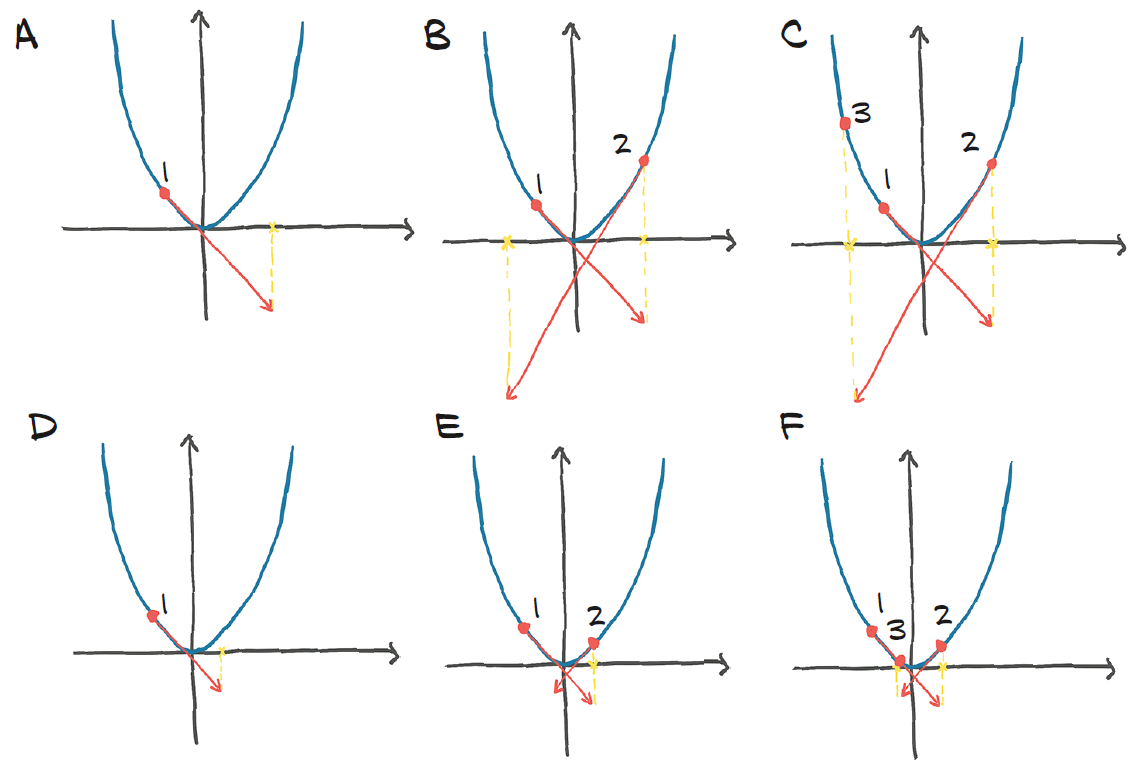

In [25]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 881.942383
    Params: tensor([ 0.7741, -0.0041])
    Grad:   tensor([2258.6482,   41.3000])
Epoch 2, Loss 446.683105
    Params: tensor([ 0.6147, -0.0071])
    Grad:   tensor([1594.2113,   29.5961])
Epoch 3, Loss 229.839371
    Params: tensor([ 0.5022, -0.0092])
    Grad:   tensor([1125.2327,   21.3351])
...
Epoch 10, Loss 16.194426
    Params: tensor([ 0.2558, -0.0146])
    Grad:   tensor([98.1817,  3.2437])
Epoch 11, Loss 15.371319
    Params: tensor([ 0.2489, -0.0149])
    Grad:   tensor([69.2917,  2.7348])
...
Epoch 99, Loss 14.534201
    Params: tensor([ 0.2325, -0.0285])
    Grad:   tensor([-0.0266,  1.5126])
Epoch 100, Loss 14.533970
    Params: tensor([ 0.2325, -0.0287])
    Grad:   tensor([-0.0266,  1.5126])


tensor([ 0.2325, -0.0287])

In [26]:
t_un = 0.1 * t_u

In [27]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 40.182171
    Params: tensor([1.3881, 0.0532])
    Grad:   tensor([-38.8070,  -5.3200])
Epoch 2, Loss 27.162054
    Params: tensor([1.6593, 0.0858])
    Grad:   tensor([-27.1191,  -3.2566])
Epoch 3, Loss 20.829231
    Params: tensor([1.8490, 0.1040])
    Grad:   tensor([-18.9752,  -1.8193])
...
Epoch 10, Loss 14.754425
    Params: tensor([2.2630, 0.0702])
    Grad:   tensor([-1.7530,  1.2140])
Epoch 11, Loss 14.712447
    Params: tensor([2.2760, 0.0572])
    Grad:   tensor([-1.3004,  1.2927])
...
Epoch 99, Loss 12.856277
    Params: tensor([ 2.5210, -1.1898])
    Grad:   tensor([-0.2420,  1.3699])
Epoch 100, Loss 12.836930
    Params: tensor([ 2.5234, -1.2035])
    Grad:   tensor([-0.2418,  1.3688])


tensor([ 2.5234, -1.2035])

In [28]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 40.182171
Epoch 2, Loss 27.162054
Epoch 3, Loss 20.829231
...
Epoch 10, Loss 14.754425
Epoch 11, Loss 14.712447
...
Epoch 99, Loss 12.856277
Epoch 100, Loss 12.836930
...
Epoch 4000, Loss 1.478868
Epoch 5000, Loss 1.466573


tensor([  5.3235, -17.0544])

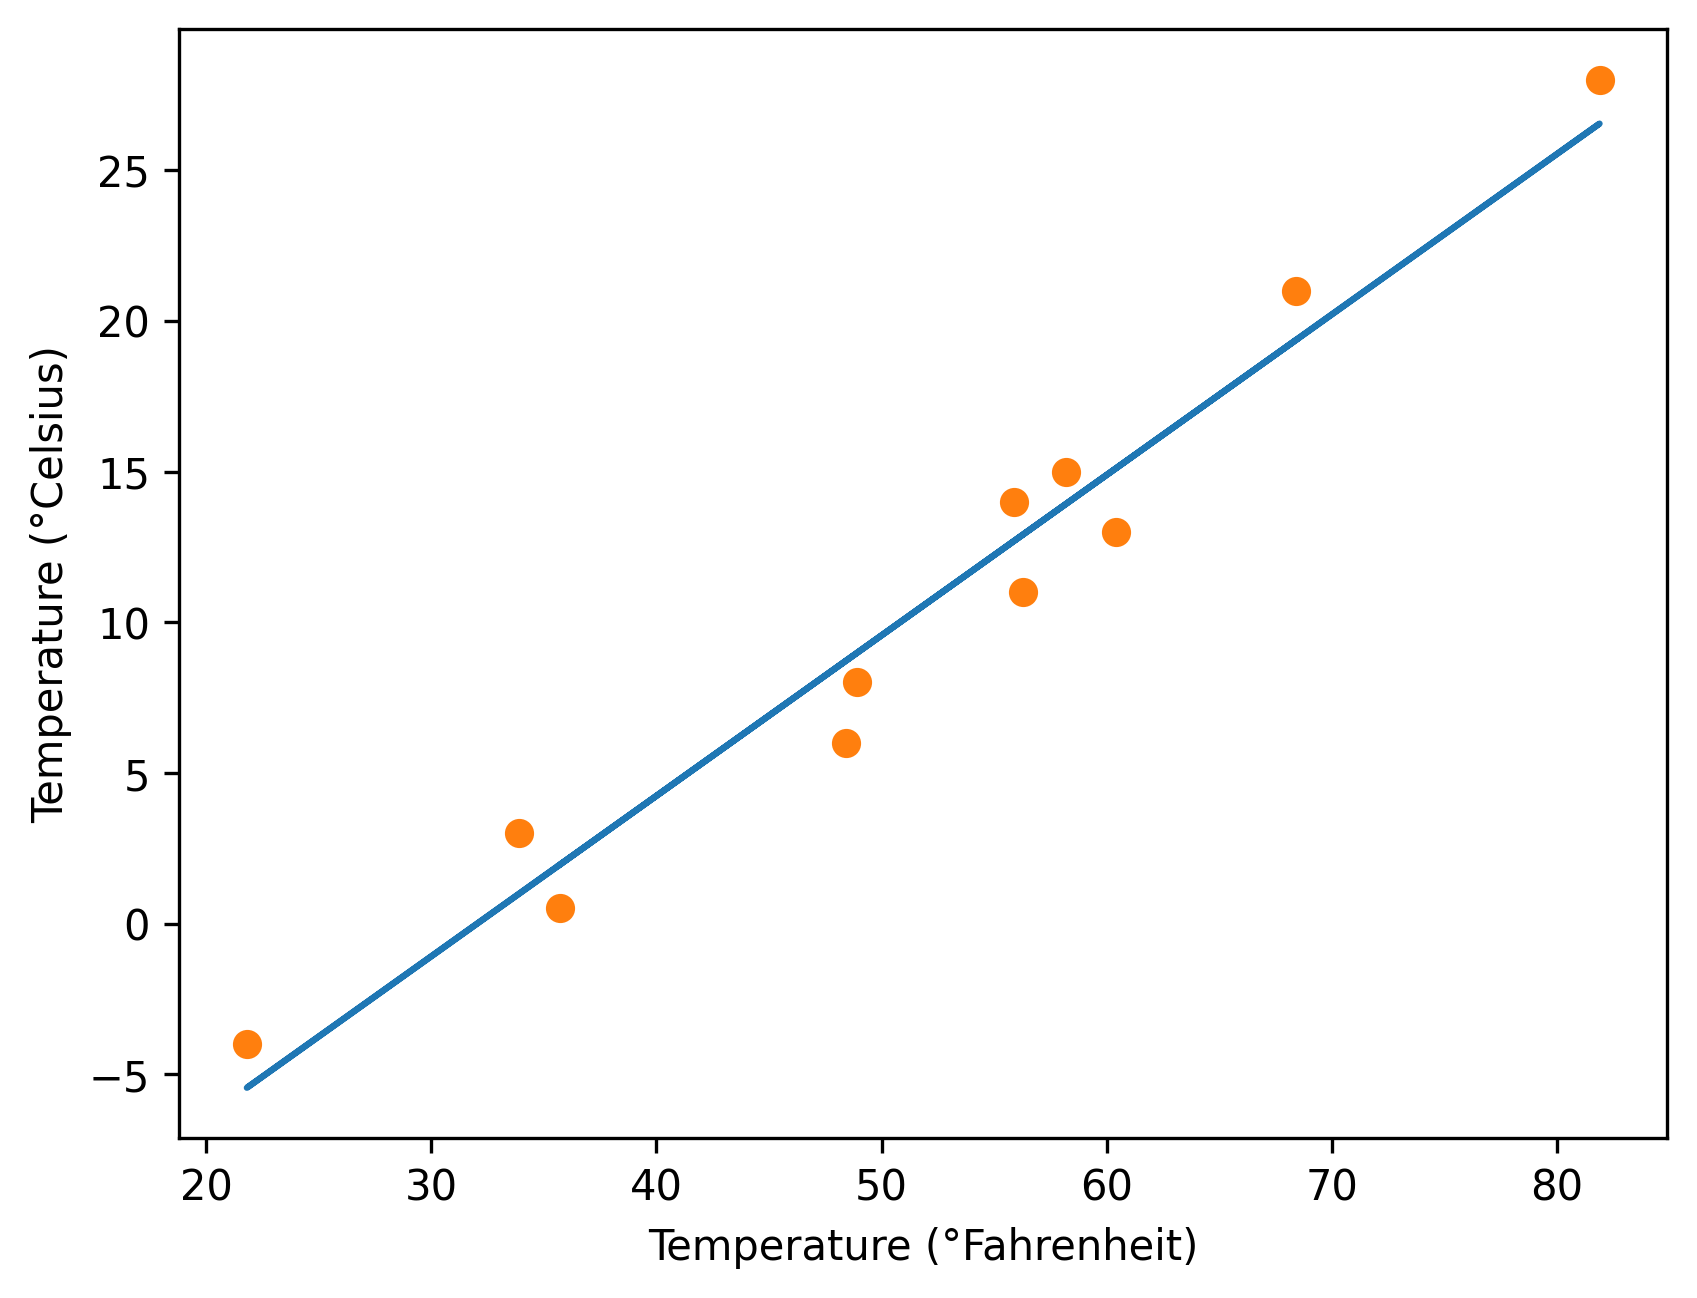

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=300)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

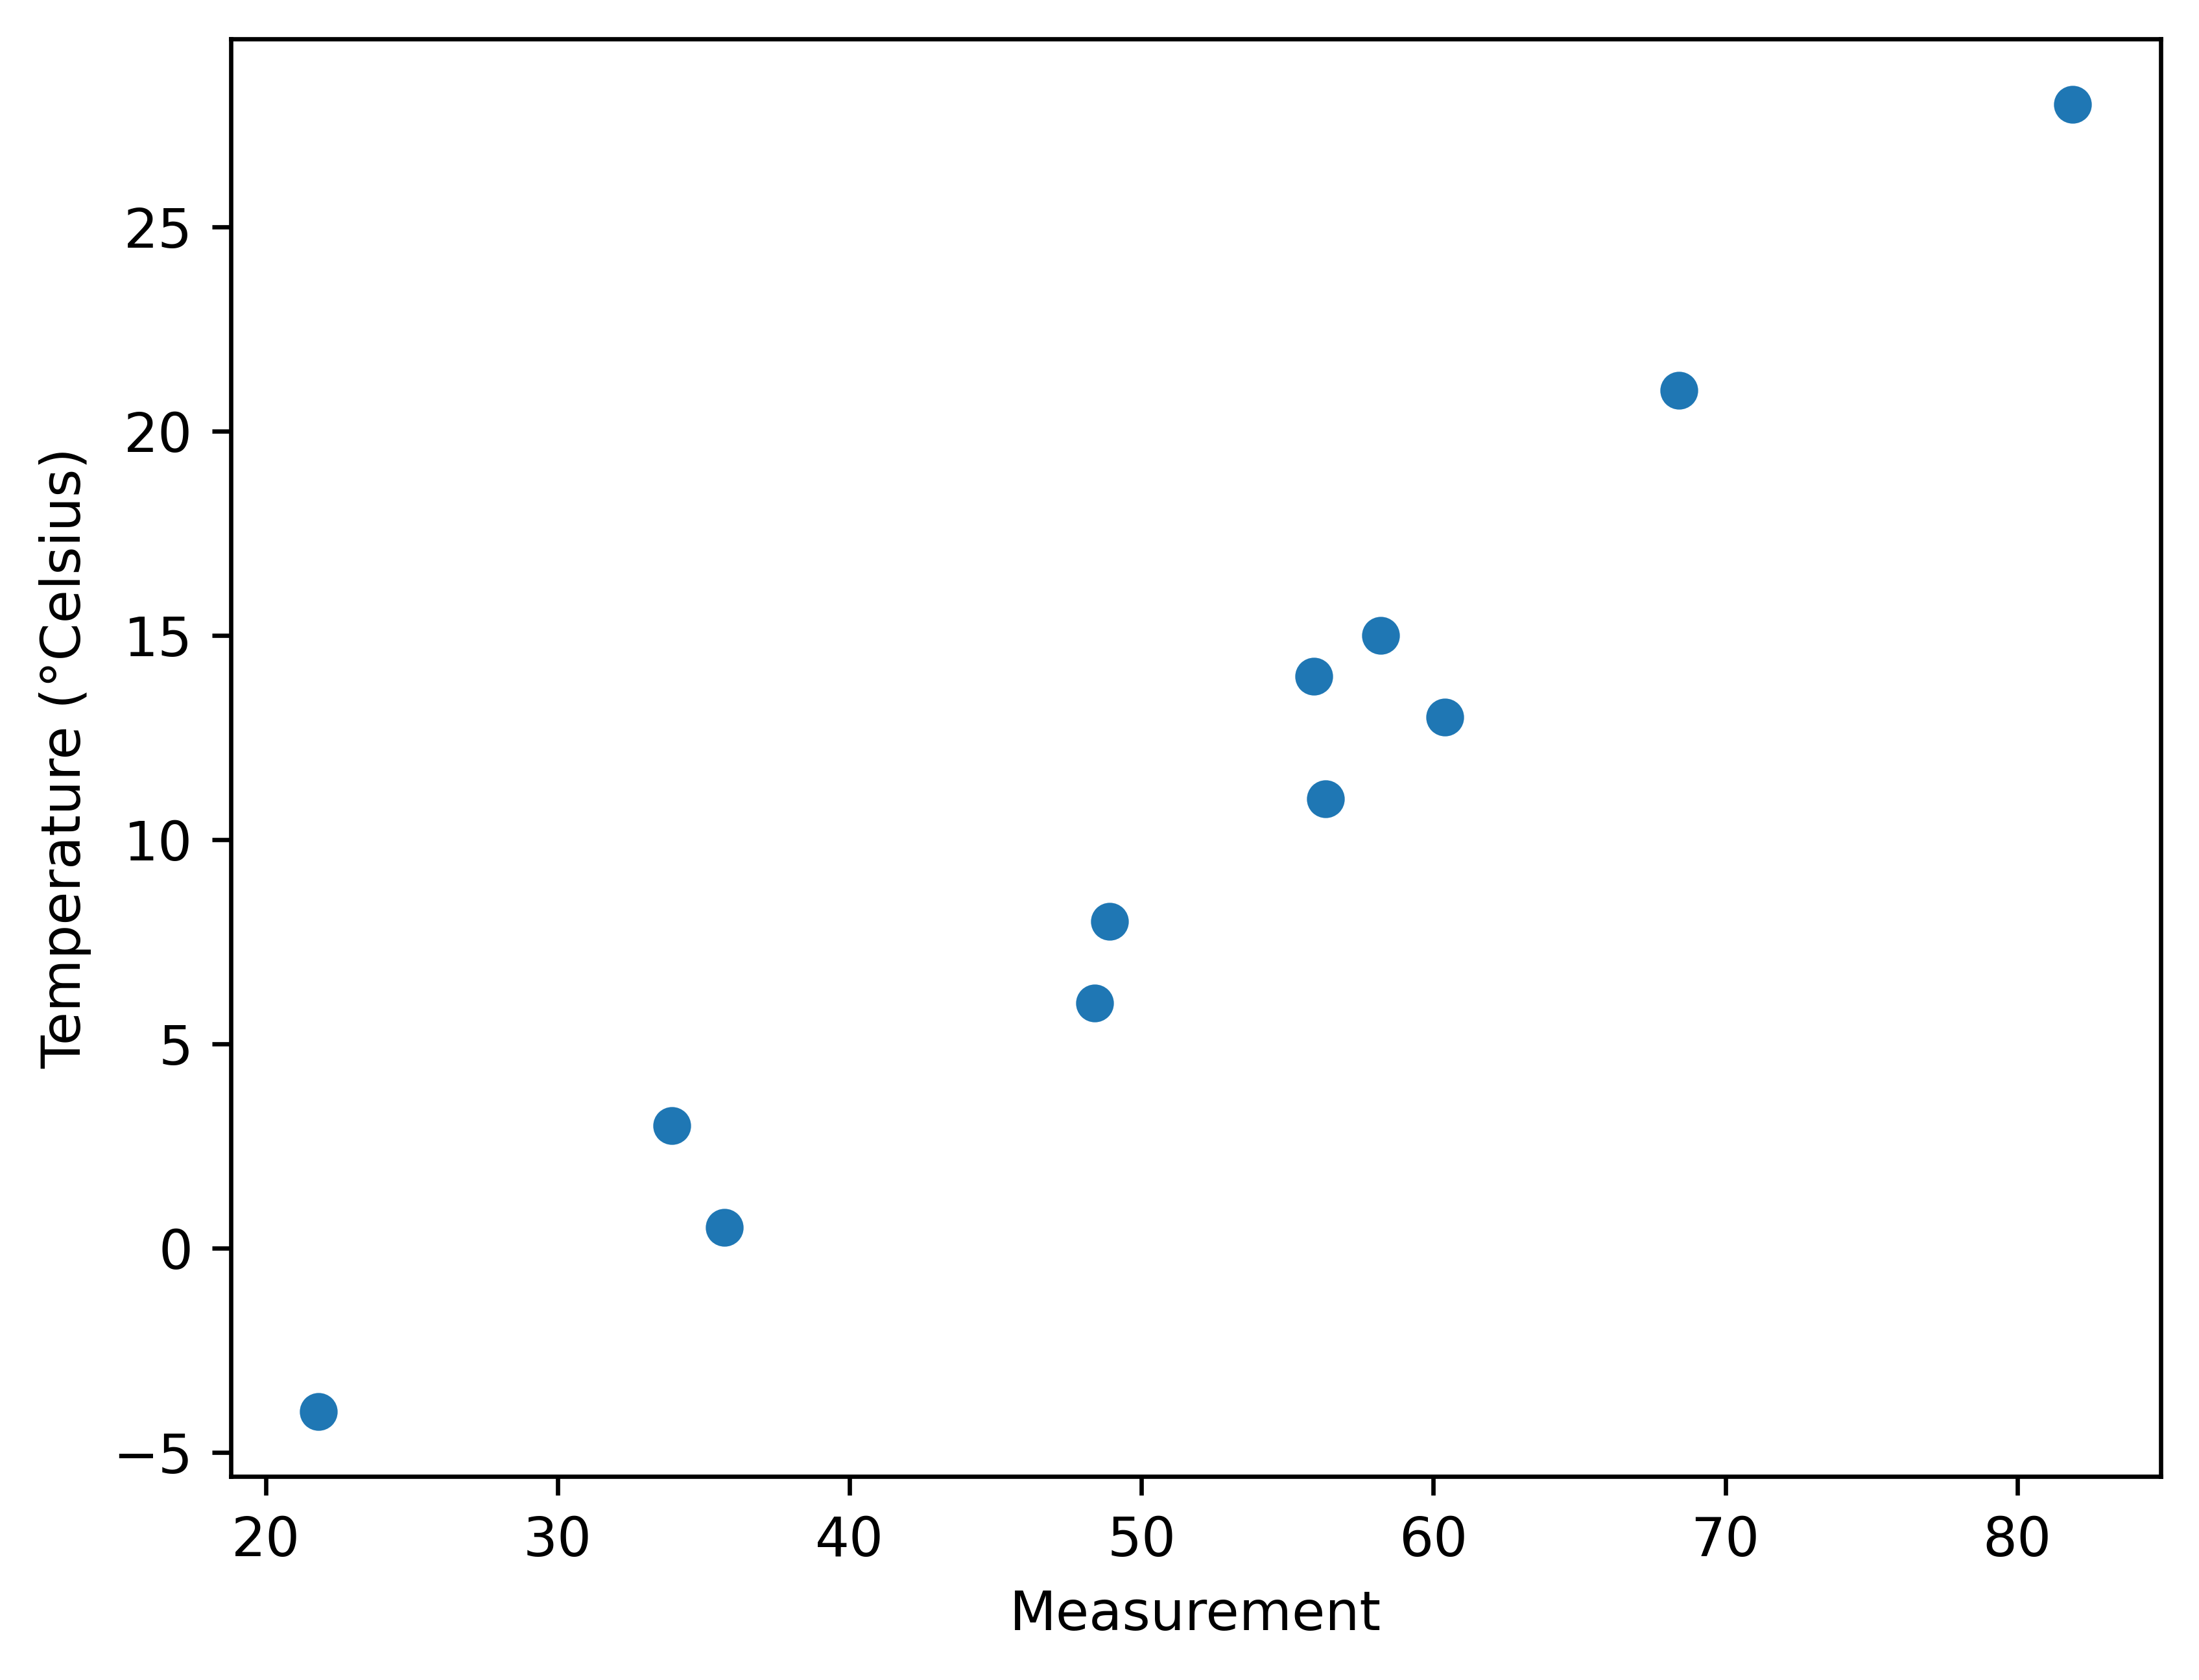

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")